In [5]:
from pathlib import Path
import os
import numpy as np
from main import load_data, empirical_iteration, null_iteration
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
from main import prior_from_weights
from joblib import Parallel, delayed
from tqdm import tqdm,trange
from generate_aggregate_figs import load_results,fit_fig,predict,get_priors,get_thresholds#,calibration_fig
from mave_calibration.evidence_thresholds import get_tavtigian_constant
from main import run

In [55]:
kwargs = dict(dataset_dir = Path("/data/dzeiberg/mave_calibration/data/"),
                results_dir = Path("/data/dzeiberg/mave_calibration/results_08_26_24/"),
                debug=True,
                lim=10000,
                dataset_name = "Matreyek_PTEN_VampSeq")

In [56]:
dataset_dir = Path(kwargs['dataset_dir'])
results_dir = Path(kwargs['results_dir'])
with open(dataset_dir / "dataset_configs.json",'r') as f:
    dataset_config = json.load(f)
X,S,sample_names, control_sample_index,mu,sigma = load_data(dataset_id=kwargs['dataset_name'],
                                                            data_directory=dataset_dir,
                                                            **dataset_config[kwargs['dataset_name']],
                                                            return_standardization=True)
results = load_results(results_dir,kwargs['dataset_name'],lim=10000)

10000it [00:01, 5671.12it/s]


In [57]:
def rejection_test(X,S,sample_names,**kwargs):
    CONFIDENCE_LEVEL = kwargs.get('confidence_level',.1)
    qmin,qmax = 100 * CONFIDENCE_LEVEL / 2, 100 * (1 - CONFIDENCE_LEVEL/2)
    test_result = run(data_directory=dataset_dir,
                        dataset_id=kwargs['dataset_name'],
                        bootstrap=False,
                        )
    test_result = dict(zip(['component_params','weights','likehoods'],test_result))
    aucs = [Parallel(n_jobs=-1)(delayed(empirical_iteration)(X[S[:,sample_num]],
                                                                test_result['component_params'],
                                                                test_result['weights'][sample_num]) \
                    for _ in range(1000)) for sample_num in range(S.shape[1])]

    null_aucs = [Parallel(n_jobs=-1)(delayed(null_iteration)(X[S[:,sample_num]]) \
                    for _ in range(1000)) for sample_num in range(S.shape[1])]
    assert len(aucs) == S.shape[1]
    empirical_intervals = [np.percentile(aucs[sample_num], [qmin,qmax]) for sample_num,sampleName in enumerate(sample_names)]
    null_intervals = [np.percentile(null_aucs[sample_num], [qmin,qmax]) for sample_num,sampleName in enumerate(sample_names)]
    for sample_num,(sampleName,empirical, null) in enumerate(zip(sample_names,empirical_intervals,null_intervals)):
        print(f"{sampleName}\n{empirical}\n{null}")
        if empirical[1] < null[0] or empirical[0] > null[1]:
            return True        
    return False


In [58]:
rejection_test(X,S,sample_names,**kwargs)

  2%|▏         | 240/10000 [00:02<01:51, 87.76it/s, likelihood=0.186902] 


p_lp
[0.46343005 0.59215024]
[0.43780343 0.56425955]
b_lb
[0.41348165 0.54625343]
[0.43516161 0.56400892]
gnomad
[0.46883328 0.57190293]
[0.44943182 0.55546677]
synonymous
[0.41959032 0.52611769]
[0.44842825 0.55488268]


False

In [59]:
# def get_thresholds(priors,quantiles=[.05,.95],posterior=False):
#     # median_prior = np.quantile(priors,0.5)
#     prior_quantiles = np.quantile(priors,quantiles)
#     quantile_pathogenic_thresholds, quantile_benign_thresholds = [],[]
#     for prior_value in prior_quantiles:
#         pathogenic_thresholds_lr,benign_thresholds_lr = thresholds_from_prior(prior_value)
#         if posterior:
#             # P = P * priors / ((P-1) * priors + 1)
#             pathogenic_thresholds = pathogenic_thresholds_lr * prior_value / ((pathogenic_thresholds_lr - 1) * prior_value + 1)
#             benign_thresholds = benign_thresholds_lr * prior_value / ((benign_thresholds_lr - 1) * prior_value + 1)
#         else:
#             pathogenic_thresholds = pathogenic_thresholds_lr
#             benign_thresholds = benign_thresholds_lr
#         quantile_pathogenic_thresholds.append(pathogenic_thresholds)
#         quantile_benign_thresholds.append(benign_thresholds)

#     return quantile_pathogenic_thresholds, quantile_benign_thresholds

def calibration_fig(X, S, sample_names, control_sample_index,dataset_name,results,ax,**kwargs):
    # rng = np.arange((xm // .01) * .01-.01,
    #                 (xM // .01) * .01 + 0.01,
    #                 .01)
    std = X.std()
    rng = np.arange(X.min() - std,X.max() + std,.01)
    priors = np.array(get_priors(results, control_sample_index)).reshape((-1,1))
    label = f"prior={np.nanquantile(priors,.5):.3f}"
    LR = predict(rng,control_sample_index,results,posterior=kwargs.get('posterior',False),priors=priors,return_all=True)
    LR_quantiles = np.nanquantile(LR,[0.05,.5,0.95],axis=0)
    # ax.plot(rng,LR_quantiles[1],color='black',label=label)
    for c,color,label in zip([0,-1],['maroon','cyan'],["5%","95%"]):
        ax.plot(rng,LR_quantiles[c],color=color,ls="-",label=label)
    if not kwargs.get('posterior',False):
        ax.set_yscale('log')
    ax.set_xlabel("Assay Score")
    if not kwargs.get('posterior',False):
        ax.set_ylabel(r"$LR^+$")
    else:
        ax.set_ylabel(r"Posterior Probability Pathogenic")
    quantile_pathogenic_thresholds, quantile_benign_thresholds = get_thresholds(priors,**kwargs)
    pathogenic_thresholds = np.stack(quantile_pathogenic_thresholds)
    benign_thresholds = np.stack(quantile_benign_thresholds)
    score_thresholds = np.ones([2,4]) * np.nan
    for strengthNum,((low,high),linestyle) in enumerate(zip(pathogenic_thresholds.T,["-","-.","--",":"])):
        label=""
        if strengthNum == 0:
            label= f"Prior Range: {np.nanquantile(priors,.05):.3f}-{np.nanquantile(priors,.95):.3f}"
        ax.fill_between(rng,low,high,alpha=.5,linestyle=linestyle,color='r',label=label)
        exceed = np.where(LR_quantiles[0] > low)[0]
        if len(exceed) == 0:
            score_thresholds[0,strengthNum] = np.nan
        else:
            score_thresholds[0,strengthNum] = rng[max(exceed)]
    for strengthNum,((low,high),linestyle) in enumerate(zip(benign_thresholds.T,["-","-.","--",":"])):
        ax.fill_between(rng,low,high,alpha=.5,linestyle=linestyle,color='b')
        exceed = np.where(LR_quantiles[-1] < high)[0]
        if len(exceed) == 0:
            score_thresholds[1,strengthNum] = np.nan
        else:
            score_thresholds[1,strengthNum] = rng[min(exceed)]
    if not kwargs.get('posterior',False):
        ax.set_ylim(benign_thresholds[0,0] * 1e-2,pathogenic_thresholds[1,0] * 1e2)
    else:
        ax.set_ylim(-.01,1.01)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # return score_thresholds
    return dict(p_lp=dict(zip(["Very Strong","Strong","Moderate","Supporting"],score_thresholds[0])),
                b_lb=dict(zip(["Very Strong","Strong","Moderate","Supporting"],score_thresholds[1])))


In [60]:
std = X.std()
rng = np.arange(X.min() - std,X.max() + std,.01)
LR_curves = predict(rng,control_sample_index,results,posterior=False,return_all=True)
priors = np.array(get_priors(results, control_sample_index))

In [61]:
def thresholds_from_prior(prior, point_values=[1,2,3,4,8]):
    exp_vals = 1 / np.array(point_values).astype(float)
    C = get_tavtigian_constant(prior)
    pathogenic_evidence_thresholds = np.ones(len(point_values)) * np.nan
    benign_evidence_thresholds = np.ones(len(point_values)) * np.nan
    for strength_idx, exp_val in enumerate(exp_vals):
        pathogenic_evidence_thresholds[strength_idx] = C ** exp_val
        benign_evidence_thresholds[strength_idx] = C ** -exp_val
    return pathogenic_evidence_thresholds[::-1], benign_evidence_thresholds[::-1]

def get_score_thresholds(LR,prior):
    lr_thresholds_pathogenic , lr_thresholds_benign = thresholds_from_prior(prior=prior)
    pathogenic_score_thresholds = np.ones(len(lr_thresholds_pathogenic)) * np.nan
    benign_score_thresholds = np.ones(len(lr_thresholds_benign)) * np.nan
    for strength_idx,lr_threshold in enumerate(lr_thresholds_pathogenic):
        exceed = np.where(LR > lr_threshold)[0]
        if len(exceed):
            pathogenic_score_thresholds[strength_idx] = rng[max(exceed)]
    for strength_idx,lr_threshold in enumerate(lr_thresholds_benign):
        exceed = np.where(LR < lr_threshold)[0]
        if len(exceed):
            benign_score_thresholds[strength_idx] = rng[min(exceed)]
    return pathogenic_score_thresholds,benign_score_thresholds

In [62]:
thresholds_results = Parallel(n_jobs=-1,verbose=10)(delayed(get_score_thresholds)(LR,prior) for LR,prior in zip(LR_curves,priors))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed: 

In [63]:
p_score_thresholds,b_score_thresholds = zip(*thresholds_results)
p_score_thresholds = np.stack(p_score_thresholds)
b_score_thresholds = np.stack(b_score_thresholds)

In [64]:
def summarize_thresholds(score_thresholds,q):
    accept = np.isnan(score_thresholds).sum(axis=0) / len(score_thresholds) < .05
    score_thresholds = np.nanquantile(score_thresholds,q=q,axis=0)
    score_thresholds[~accept] = np.nan
    return score_thresholds

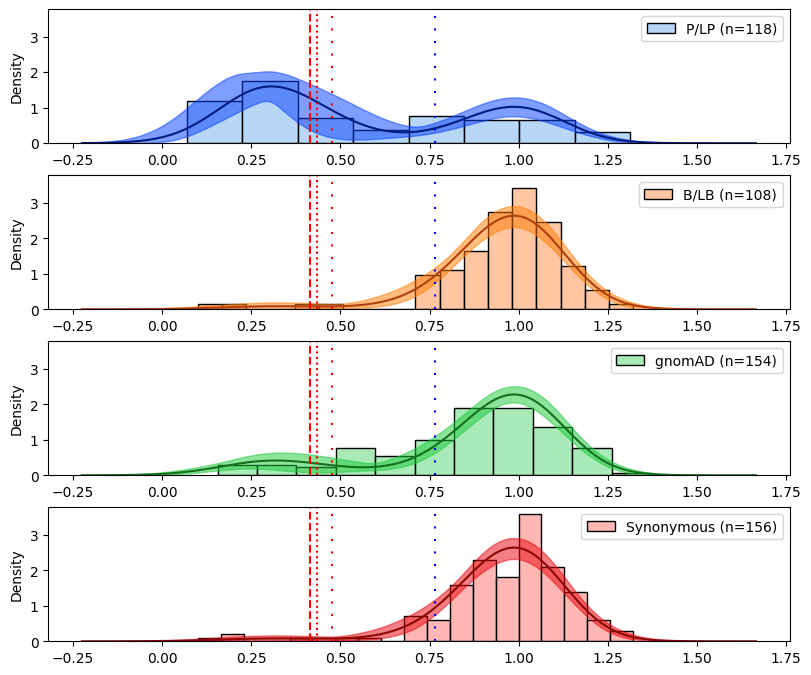

In [65]:
NSamples = S.shape[1]
fig = plt.figure(layout="constrained", figsize=(8,(NSamples) * 3))

gs = GridSpec(NSamples + 4, 1, figure=fig,)
topAxs = [fig.add_subplot(gs[i, 0]) for i in range(NSamples)]

fit_fig(X,S,sample_names,kwargs['dataset_name'],results,topAxs)


linestyles = [(0, (1,5)),'dotted','dashed','dashdot','solid']
for s,linestyle in zip(summarize_thresholds(p_score_thresholds,.05),linestyles):
    if np.isnan(s):
        continue
    for axi in topAxs:
        axi.axvline(s,color='r',linestyle=linestyle)
for s,linestyle in zip(summarize_thresholds(b_score_thresholds,.95),linestyles):
    if np.isnan(s):
        continue
    for axi in topAxs:
        axi.axvline(s,color='b',linestyle=linestyle)

ymax = float(max([axi.get_ylim()[1] for axi in topAxs]))
for axi in topAxs:
    axi.set_ylim(0,ymax)

In [66]:
fig.savefig(f"/data/dzeiberg/mave_calibration/results_08_26_24/figs/{kwargs['dataset_name']}.jpeg",
            format='jpeg',
            bbox_inches='tight',
            dpi=300)